In [1]:
import time
import numpy as np
import pymc3 as pm
import pandas as pd
from tqdm import tqdm
import os

from numba import jit

import arviz as az
import matplotlib.pyplot as plt

import theano
import theano.tensor as t
from scipy.integrate import solve_ivp

THEANO_FLAGS = 'optimizer=fast_compile', 'exception_verbosity=high'
SEED = 1234

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Leitura e tratamento dos arquivos csv gerados

dfR2 = pd.read_csv(r"C:\Users\thais\Downloads\resistentes-dados_reais\resistentes4000_dados-reais3.csv", sep=';', header=None)
dfR2.columns = ['hours', 'cell_index']
dfR2 = dfR2.replace({',':'.'}, regex=True)
dfR2 = dfR2.astype(float)
#dfS2.info()

In [3]:
#obter somente menores do que 97 horas

dfr2 = dfR2[dfR2['hours'] < 97]
print(len(dfr2))

79


In [4]:
xdados2 = np.array(dfr2['hours'].values)
ydados2 = np.array(dfr2['cell_index'].values)

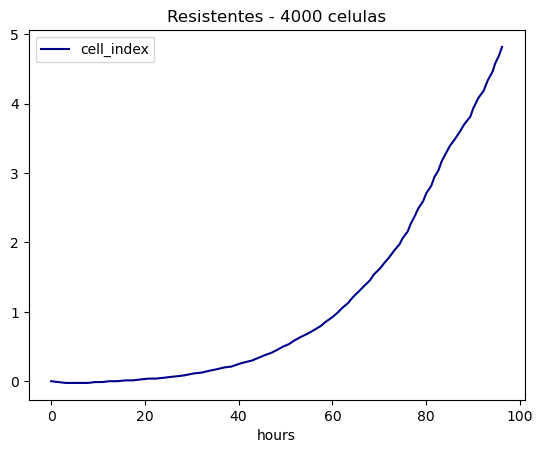

In [5]:
dfr2.plot(x='hours', y='cell_index', c='DarkBlue', title='Resistentes - 4000 celulas')
plt.show()

In [6]:
# Modelo
def model01(t, X, taur, r0):
    R = X
    K = 8.2538
   
    dRdt = R/taur * (1 - (R)/K)

    return dRdt

In [7]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dscalar, t.dscalar], otypes=[t.dmatrix])
def wrapper1(time_exp2, taur, r0):
    t_span2 = (0.0, time_exp2.max())

    y02 = np.array([r0])    
    y_model2 =  solve_ivp(
        fun = lambda t, y: model01(t, y, taur=taur, r0=r0),
        t_span=t_span2,
        y0=y02,
        t_eval=time_exp2,
        method='LSODA'    
    )

    simulated_time2 = y_model2.t
    simulated_ode_solution2 = y_model2.y
    R2 = simulated_ode_solution2

    return R2

In [8]:
print('\n*** Performing Bayesian Calibration ***')
print('-- Running Monte Carlo Simulations')

y_conc = ydados2 
observations = y_conc #ydados2
draws = 5000
start_time = time.time()

with pm.Model() as model_smc:

#Priors
    
    r0 = pm.Uniform('r0', lower=0.000001, upper=1.0)
    taur = pm.Uniform('taur', lower=1.0, upper=50.0)

    sigma2 = pm.Uniform('sigma2', lower=0.0001, upper=5.0)

    #simulando para 1-1, 3-1, 7-1
    fitting_model = pm.Deterministic(
        'model01',
        wrapper1(
            theano.shared(xdados2),
            taur,
            r0
        )
    )

    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model, sigma=sigma2, observed=observations)
    trace_calibration1 = pm.sample_smc(draws, chains=1, parallel=False, cores=1, random_seed = SEED)

duration = time.time() - start_time
print(f'-- Monte Carlo simulations done in {duration / 60:.3f} minutes.')


*** Performing Bayesian Calibration ***
-- Running Monte Carlo Simulations


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.015
Stage:   1 Beta: 0.033
Stage:   2 Beta: 0.049
Stage:   3 Beta: 0.065
Stage:   4 Beta: 0.085
Stage:   5 Beta: 0.109
Stage:   6 Beta: 0.154
Stage:   7 Beta: 0.296
Stage:   8 Beta: 0.683
Stage:   9 Beta: 1.000


-- Monte Carlo simulations done in 7.424 minutes.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


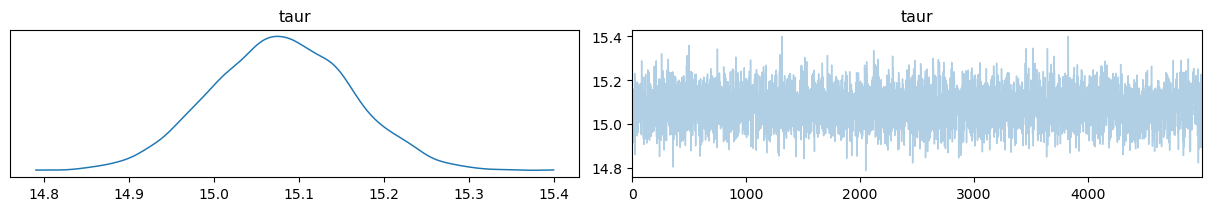

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


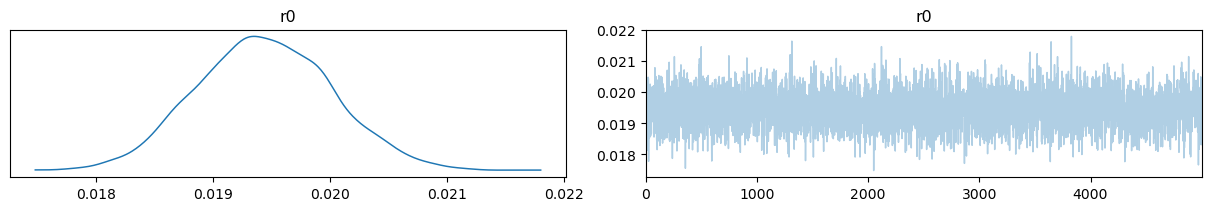

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


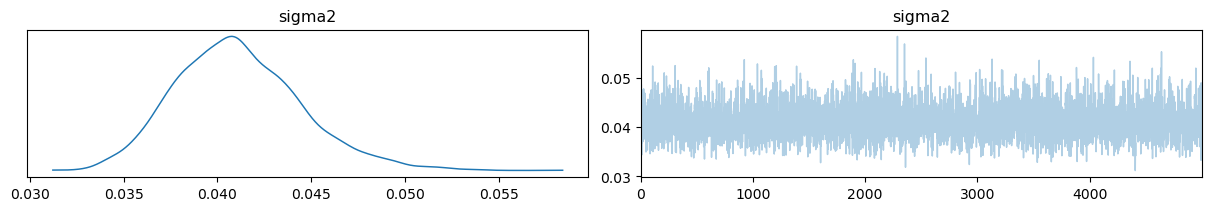

In [9]:
#Plot de cada cadeia

az.plot_trace(trace_calibration1, var_names=('taur'))
plt.savefig('cadeia-tau_r4000_calibrandor0-logistico.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('r0'))
plt.savefig('cadeia-r0-4000_calibrandor0-logistico.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('sigma2'))
plt.savefig('cadeia-sigma-4000_calibrandor0-logistico.png')
plt.show()

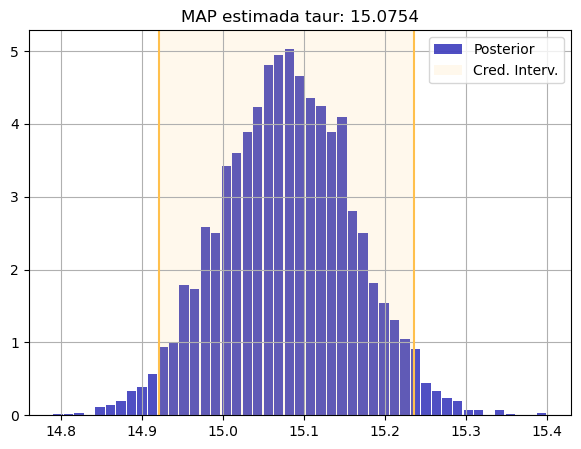

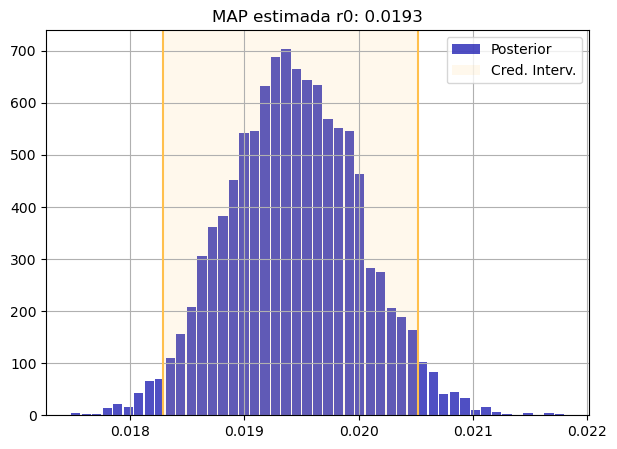

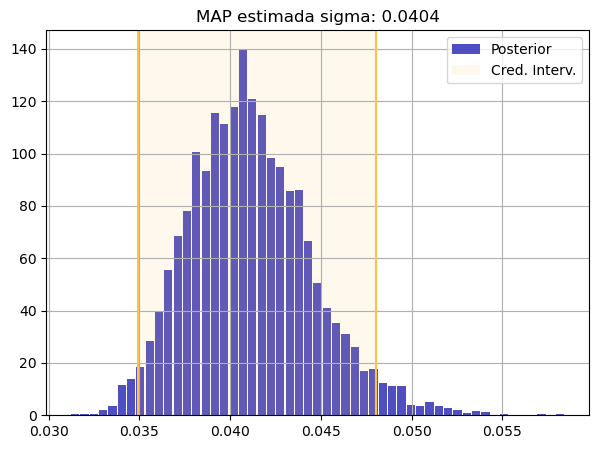

In [10]:
#Plot de cada MAP

import arviz

fig, ax = plt.subplots(figsize = (7, 5))
n, bins, patches = plt.hist(x=trace_calibration1['taur'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['taur'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada taur: {0:.4f}'.format(bins[np.argmax(n)]) )
plt.grid()
plt.legend()

plt.savefig('MAP_taur_resistentes-4000_calibrando_r0-logistico.png')
plt.show()

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['r0'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['r0'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada r0: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()
plt.legend()

plt.savefig('MAP_r0_resistentes-4000_calibrando_r0-logistico.png')
plt.show()

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['sigma2'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['sigma2'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada sigma: {0:.4f}'.format(bins[np.argmax(n)]))   
plt.grid()
plt.legend()

plt.savefig('MAP_sigma_resistentes-4000_calibrando_r0-logistico.png')
plt.show()


In [11]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration1["model01"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration1["model01"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration1["model01"], 50, axis=0)

In [12]:
y_min[0:79]

print(len(y_min[0:79]))

minimo = np.reshape(y_min[0:79], (79,))

print(len(minimo))

y_max[0:79]

print(len(y_max[0:79]))

maximo = np.reshape(y_max[0:79], (79,))

print(len(maximo))

y_fit[0:79]

print(len(y_fit[0:79]))

fit = np.reshape(y_fit[0:79], (79,))

print(len(fit))

1
79
1
79
1
79


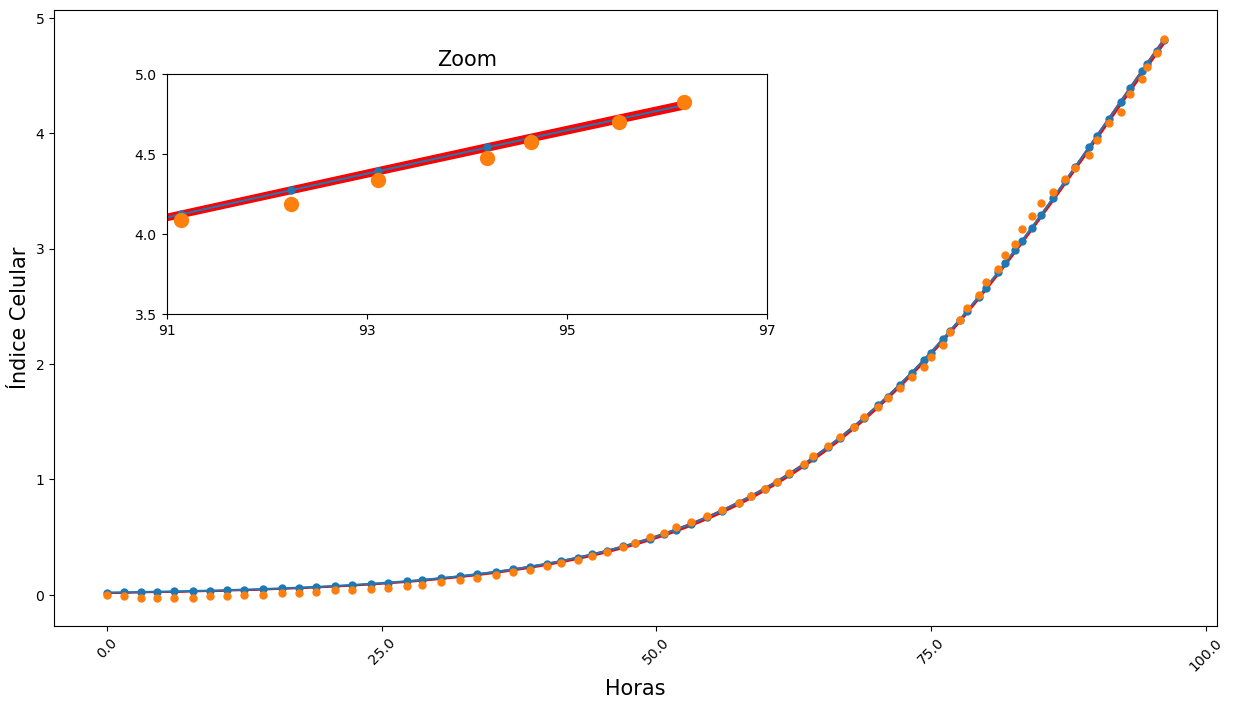

In [13]:
plt.figure(figsize=(15, 8))

# criação do primeiro conjunto de eixos
ax1 = plt.axes() 
ax1.plot(
    xdados2,
    fit,
    label="Simulação",
    marker=".",
    linestyle="-",
    markersize=10,
)
ax1.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax1.plot(
    xdados2, ydados2, label="Dados células resistentes (2)", marker="o", linestyle="", markersize=5
)
#plt.grid()
t = np.linspace(0, 100, 5)
#ax1.legend(shadow=True)
ax1.set_xticks(t)
ax1.set_xticklabels(t, rotation=45)
ax1.set_xlabel('Horas', fontsize=15)
ax1.set_ylabel('Índice Celular', fontsize=15)

#plt.legend(loc="lower right")

# criação do segundo conjunto de eixos
ax2 = plt.axes([0.2, 0.5, 0.4, 0.3])
ax2.plot(xdados2,fit, marker=".", linestyle="-", markersize=10)
ax2.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax2.plot(xdados2, ydados2,  marker="o", linestyle="", markersize=10)
ax2.set_xlim(91.0, 97.0)
ax2.set_ylim(3.5, 5.0)
ax2.set_xticks([91.0, 93.0, 95.0, 97.0])
ax2.set_yticks([3.5, 4.0, 4.5, 5.0])
#ax2.set_xlabel('Horas', fontsize=10)
#ax2.set_ylabel('Índice Celular', fontsize=10)
ax2.set_title('Zoom', fontsize=15)

plt.savefig('matplotlib_resistentes-logistico_calibrando_r0.png')

plt.show()

In [14]:
#Critério BIC

soma_logis = sum((fit - ydados2)**2.0)

def bic(sum_qd, qt_params, vec_size):
    
    return (vec_size * np.log(sum_qd / vec_size) + qt_params * np.log(vec_size))

bic_result = bic(soma_logis,3,79)

print(bic_result)

-495.8800523517613
